In [63]:
# Importing Functions and Libraries
import numpy as np
from matplotlib import pyplot
from Derivatives import FiniteDifference_2D, FiniteDifference_2D_single

from GhostCells import Ghost_Cells
from TimeStep import Time_Step
from Equations_State import EquationOfState



In [64]:
#Parameters
dim     = 2         # Number of dimensions 2D, but for primative and conserved variables 4 equns
                    # [continuity, momentum_x, momentum_y, energy]
                    # In primative currently [rho, u, v, e + kinetic energy]
                    # In conserved currently [rho*u, rho*u*u + P, rho*u*v, E]

Nx      = 100       # Number of Nodes  
Ny      = 100        # Number of Nodes     

x_start = 0         # Physical X Start
x_end   = 2*np.pi   # Physical X End

y_start = 0         # Physical Y Start
y_end   = 2*np.pi   # Physical Y End

order   = 4         # Order for derivatives
t_start = 0         # Start time
t_end   = 5         # End time
iter_end = 100000

CFL     = 0.1       # Courant-Friedrichs-Lewy number

# Re, Ma and L
Re      = 10.0              # Reynolds number
Ma      = 0.2               # Mach number
L_0     = 2*np.pi           # Length scale in m

# Inital Pressure Temperature
P_0     = 100000            # Initial pressure in Pa
T_0     = 300               # Initial temperature in K

# Gas Properties
R_u     = 8.31446261815324  # Universal gas constant in J/(mol·K)
m_air   = 28.96/1000        # Molar mass of dry air in kg/mol
gamma   = 7.0/5.0           # Ratio of specific heats
R_s     = R_u/m_air         # Specific gas constant in J/(kg·K)

V_0     = Ma * np.sqrt(gamma * R_s * T_0)  # Velocity in m/s

rho_0   = P_0/(R_s*T_0)     # Initial density in kg/m^3, from ideal gas
mu      = rho_0*V_0*L_0/Re  # kg/m^1/s
Pr      = 0.71              # Prandtl number
C_v     = R_s / (gamma-1)   
C_p     = R_s + C_v         # Specific heat capacity at constant pressure in J/(kg·K)
kappa   = mu * C_p / Pr     # Thermal conductivity in W/(m·K)


plot_time = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.9, 5.0]    # Plot times
#plot_time = [0.01, 0.02]    # Plot times



In [65]:
# Basic Calculations Setting Up
# Secondary Parameters
ngc         = Ghost_Cells.number_ghost_cells(order)

dx          = (x_end - x_start) / Nx # mesh resolution
dy          = (y_end - y_start) / Ny # mesh resolution

x           = np.linspace(x_start + dx/2 - ngc*dx , x_end - dx/2 + ngc*dx, Nx + 2*ngc) # Range x values with ghost cells and fluid domain
y           = np.linspace(y_start + dy/2 - ngc*dy , y_end - dy/2 + ngc*dy, Ny + 2*ngc) # Range y values with ghost cells and fluid domain

X, Z        = np.meshgrid(x, y)    #For Contour Plotting

# Initalize Variables
V               = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Primative Variables
                                                                    # density + 2 dim of velocity + energy
Q               = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Conservative Variables
                                                                    # density + 2 dim of momentum + energy
P               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Pressure 
T               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Temperature                                                                               
                                                    
tau             = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 2))       # Stress Tensor
tau_xx          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_yy          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_xy          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
tau_yx          = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
                                                            
Cx              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Convective flux x term
Cy              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Convective flux y term
Dx              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Diffusive flux x term
Dy              = np.zeros((Nx + 2*ngc, Ny + 2*ngc, dim + 3))       # Diffusive flux y term

e               = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Internal Energy
vorticity       = np.zeros((Nx + 2*ngc, Ny + 2*ngc))                # Vorticity


# Y
Y               = np.zeros((Nx + 2*ngc, Ny + 2*ngc, 2))           # Mass Fraction

#For left side
Y[ngc:len(x)//2,ngc:-ngc,0]         = 1
Y[ngc:len(x)//2,ngc:-ngc,1]         = 1 - Y[ngc:len(x)//2,ngc:-ngc,0] 

#FOr right side
Y[len(x)//2:-ngc,ngc:-ngc,0]        = 2
Y[len(x)//2:-ngc,ngc:-ngc,1]        = 1 - Y[len(x)//2:-ngc,ngc:-ngc,0] #Y[len(x)//2:-ngc,ngc:-ngc,0]  


print(Y[ngc:-ngc,ngc:-ngc,0])
# print(Y[ngc:-ngc,ngc:-ngc,1])

# print(Y.shape)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [55]:
def initial_condition_TGV(V, V_0, P, P_0, rho_0, e, T, T_0, C_v, Nx, Ny, x, y, order):

    ngc = Ghost_Cells.number_ghost_cells(order)

    for i in range(Nx + 2*ngc):
        for j in range(Ny + 2*ngc):
            
            V[i,j,0]    = rho_0
            V[i,j,1]    =  V_0 * np.sin(x[i])*np.cos(y[j])                      # Velocity in x direction, u
            V[i,j,2]    = -V_0 * np.cos(x[i])*np.sin(y[j])                      # Velocity in y direction, intitialy 1 m/s, v
            
            P[i,j]      = P_0+(np.cos(2*x[i]) + np.cos(2*y[j]))*(rho_0/16.0)    # Pressure  
            T[i,j]      = T_0
           
    e = EquationOfState.internal_energy_from_temperature(T, C_v, order)  # internal energy
    
    V[:,:,3] = e[:,:] + 0.5*(V[:,:,1]**2 + V[:,:,2]**2)                  # energy, e + 0.5*(u^2 + v^2)
    
    # fill gc here
    V = Ghost_Cells.fill_ghost_cells_2D(V, order)
    P = Ghost_Cells.fill_ghost_cells_2D_single(P, order)
    T = Ghost_Cells.fill_ghost_cells_2D_single(T, order)
    e = Ghost_Cells.fill_ghost_cells_2D_single(e, order)
    
    return V, P, T, e
    

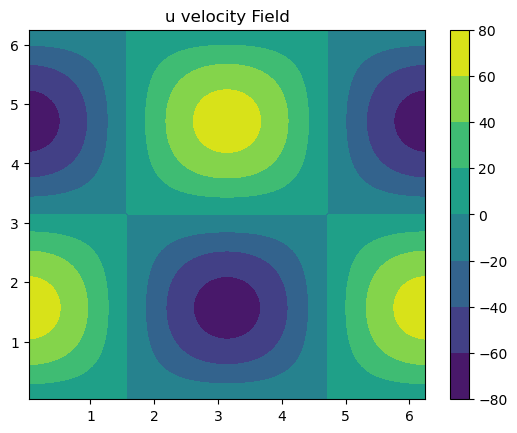

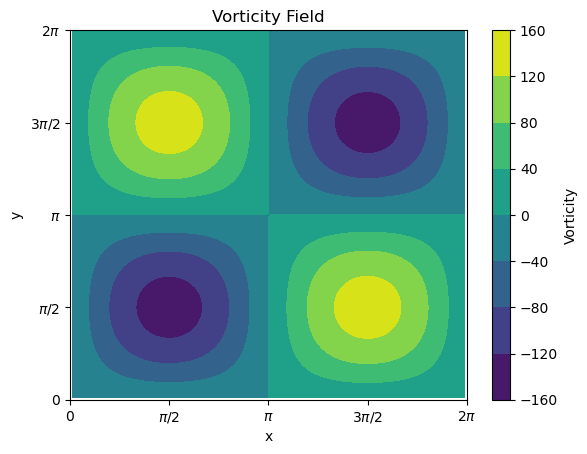

In [56]:
#
# # Check if the initial condition is correct:
# 
V, P, T, e     = initial_condition_TGV(V, V_0, P, P_0, rho_0, e, T, T_0, C_v, Nx, Ny, x, y, order)
X, Z        = np.meshgrid(x[ngc:-ngc], y[ngc:-ngc])
fig         = pyplot.figure()
ax1         = pyplot.contourf(X, Z, V[ngc:-ngc,ngc:-ngc,1])
pyplot.title('u velocity Field')

pyplot.colorbar()
pyplot.show()

dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order)
dV_dy = FiniteDifference_2D.df_dy_2D(V, dx, order)

# Initial Vorticity

vorticity = dV_dy[:,:,1] - dV_dx[:,:,2]  # Vorticity

# Plot the vorticity field
fig = pyplot.figure()
ax2 = pyplot.contourf(X, Z, vorticity[ngc:-ngc, ngc:-ngc])
pyplot.colorbar(ax2, label='Vorticity')
pyplot.xlabel('x')
pyplot.ylabel('y')

# Set x and y axis in terms of pi
xticks = np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)
xtick_labels = ['0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$']
pyplot.xticks(xticks, xtick_labels)
pyplot.yticks(xticks, xtick_labels)

pyplot.title('Vorticity Field')
pyplot.show()



In [57]:
# calculate tau
def calculate_tau(tau, dV_dx, dV_dy, mu, order):
    # tau_xx = (2/3) * mu * (2 * du/dx - dv/dy)
    # tau_yy = (2/3) * mu * (2 * dv/dy - du/dx)
    # tau_xy = mu * (du/dy + dv/dx)
    # tau_yx = tau_xy
    
    tau[ngc:-ngc,ngc:-ngc,0] = (2.0/3.0) * mu * (2 * dV_dx[ngc:-ngc,ngc:-ngc,1] - dV_dy[ngc:-ngc,ngc:-ngc,2])
    tau[ngc:-ngc,ngc:-ngc,1] = (2.0/3.0) * mu * (2 * dV_dy[ngc:-ngc,ngc:-ngc,2] - dV_dx[ngc:-ngc,ngc:-ngc,1])
    tau[ngc:-ngc,ngc:-ngc,2] = mu * (dV_dy[ngc:-ngc,ngc:-ngc,1] + dV_dx[ngc:-ngc,ngc:-ngc,2])
    tau[ngc:-ngc,ngc:-ngc,3] = tau[ngc:-ngc,ngc:-ngc,2]
 
    #Fill ghost cells
    tau = Ghost_Cells.fill_ghost_cells_2D(tau, order)
    
    tau_xx = tau[:,:,0]
    tau_yy = tau[:,:,1]
    tau_xy = tau[:,:,2]
    tau_yx = tau[:,:,3]
    
    return tau, tau_xx, tau_yy, tau_xy, tau_yx

In [58]:
def get_Q_from_V(V, Q, order):
    # Q[0] = rho * Y[0]
    # Q[1] = rho*u
    # Q[2] = rho*v
    # Q[3] = E, rho*(e + 0.5*(u^2 + v^2))
    # Q[4] = rho * Y[1]
    Q[:,:,0] = V[:,:,0] * Y[:,:,0]
    Q[:,:,1] = V[:,:,0] * V[:,:,1] 
    Q[:,:,2] = V[:,:,0] * V[:,:,2]
    Q[:,:,3] = V[:,:,0] * V[:,:,3] 
    Q[:,:,4] = V[:,:,0] * Y[:,:,1]
    Q = Ghost_Cells.fill_ghost_cells_2D(Q, order)
    
    return Q 

In [59]:
def get_V_from_Q(Q, V, order):
    # V[0] = rho
    # V[1] = u
    # V[2] = v
    # V[3] = e + 0.5*(u^2 + v^2)
    # V[4] = rho
    V[:,:,0] = Q[:,:,0] / Y[:,:,0]
    V[:,:,1] = Q[:,:,1] / V[:,:,0] 
    V[:,:,2] = Q[:,:,2] / V[:,:,0]
    V[:,:,3] = Q[:,:,3] / V[:,:,0]
    V[:,:,4] = V[:,:,0] 
    
    V = Ghost_Cells.fill_ghost_cells_2D(V, order)
    
    return V

In [60]:
def get_Convective_flux(V, Q, Cx, Cy, P, order):
    # Cx[0] = rho*u * Y[0]
    # Cx[1] = rho*u^2 + P
    # Cx[2] = rho*u*v
    # Cx[3] = E*u
    # Cx[4] = rho*u*Y[1]
    Cx[:,:,0] = Q[:,:,1] * Y[:,:,0]
    Cx[:,:,1] = Q[:,:,1]*V[:,:,1] + P[:,:]
    Cx[:,:,2] = Q[:,:,1]*V[:,:,2] 
    Cx[:,:,3] = (Q[:,:,3] + P[:,:])*V[:,:,1]
    Cx[:,:,4] = Q[:,:,1] * Y[:,:,1]
    # Cy[0] = rho*v * Y[0]
    # Cy[1] = rho*u*v
    # Cy[2] = rho*v^2 + P
    # Cy[3] = E*v
    # Cy[4] = rho*v*Y[1]
    Cy[:,:,0] = Q[:,:,2] * Y[:,:,0]
    Cy[:,:,1] = Q[:,:,1]*V[:,:,2]
    Cy[:,:,2] = Q[:,:,2]*V[:,:,2] + P[:,:]
    Cy[:,:,3] = (Q[:,:,3] + P[:,:])*V[:,:,2]
    Cy[:,:,4] = Q[:,:,2] * Y[:,:,1]
    
    # Fill ghost cells
    Cx = Ghost_Cells.fill_ghost_cells_2D(Cx, order)
    Cy = Ghost_Cells.fill_ghost_cells_2D(Cy, order)
    
    return Cx, Cy

In [61]:
def get_Diffusive_flux(V, Q, dT_dx, dT_dy, Dx, Dy, tau_xx, tau_yy, tau_xy, tau_yx, gamma, order):
    
    # Dx[0] = rho* D * Grad(Y[0]) 
    # Dx[1] = tau_xx
    # Dx[2] = tau_xy
    # Dx[3] = tau_xx*u + tau_xy*v + gamma*dT/dx
    # Dx[4] = rho * D * Grad(Y[1])
    Dx[:,:,0] =  V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dx_2D(Y[:,:,0],dx,order))
    Dx[:,:,1] = tau_xx
    Dx[:,:,2] = tau_xy
    Dx[:,:,3] = tau_xx*V[:,:,1] + tau_xy*V[:,:,2] + kappa*dT_dx[:,:] \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dx_2D(Y[:,:,0],dx,order) \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dx_2D(Y[:,:,1],dx,order)
    Dx[:,:,4] = V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dx_2D(Y[:,:,1],dx,order))
    # Dy[0] = rho* D * Grad(Y[0]) 
    # Dy[1] = tau_yx
    # Dy[2] = tau_yy
    # Dy[3] = tau_yx*u + tau_yy*v + gamma*dT/dy
    # Dy[4] = rho * D* * Grad(Y[1])
    Dy[:,:,0] = V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dy_2D(Y[:,:,0], dy, order))
    Dy[:,:,1] = tau_yx
    Dy[:,:,2] = tau_yy
    Dy[:,:,3] = tau_yx*V[:,:,1] + tau_yy*V[:,:,2] + kappa*dT_dy[:,:] \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dy_2D(Y[:,:,0],dy,order) \
                + C_p * T[:,:] * V[:,:,0] * 1 * FiniteDifference_2D_single.df_dy_2D(Y[:,:,1],dy,order)
    Dy[:,:,4] = V[:,:,0] * 1 * (FiniteDifference_2D_single.df_dy_2D(Y[:,:,1], dy, order))
    
    
    #Fill ghost cells
    Dx = Ghost_Cells.fill_ghost_cells_2D(Dx, order)
    Dy = Ghost_Cells.fill_ghost_cells_2D(Dy, order)
    
    return Dx, Dy

/tmp/ipykernel_12166/4007786380.py:7: RuntimeWarning: divide by zero encountered in divide
  V[:,:,0] = Q[:,:,0] / Y[:,:,0]


Current time: 0.01, dt: 5.370152481838988e-06, i: 0, plot_time[i]: 0.01


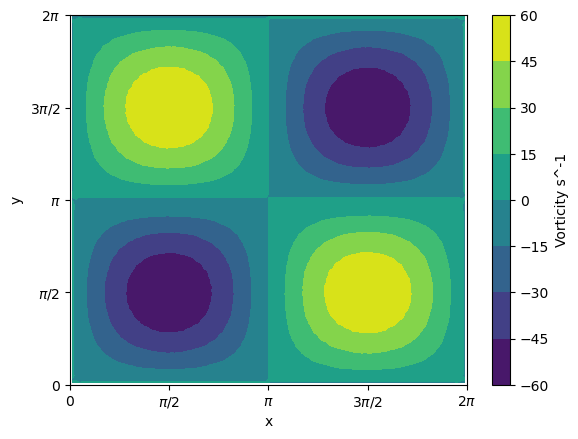

Current time: 0.02, dt: 6.31354545743007e-06, i: 1, plot_time[i]: 0.02


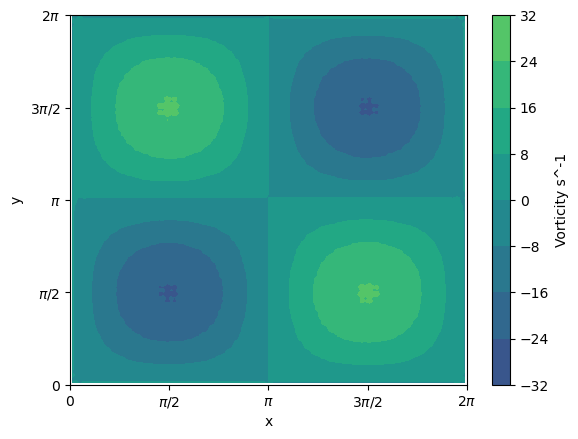

Current time: 0.03, dt: 4.674232645753007e-06, i: 2, plot_time[i]: 0.03


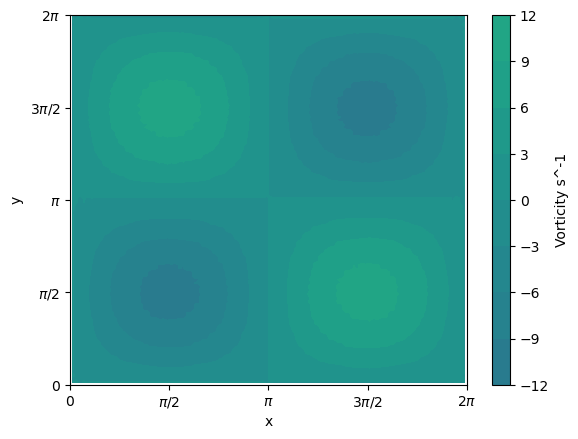

Current time: 0.04, dt: 5.71337558456092e-06, i: 3, plot_time[i]: 0.04


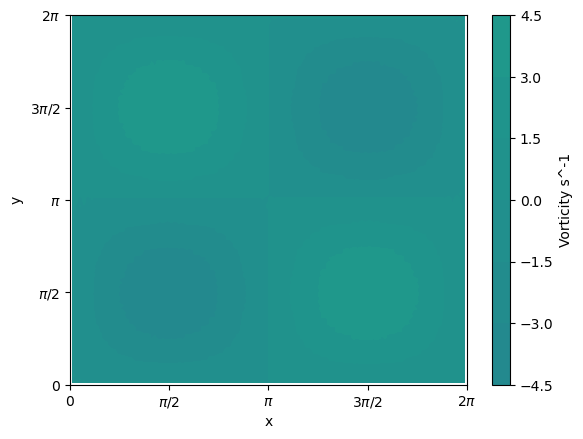

Current time: 0.05, dt: 3.7237553318775207e-06, i: 4, plot_time[i]: 0.05


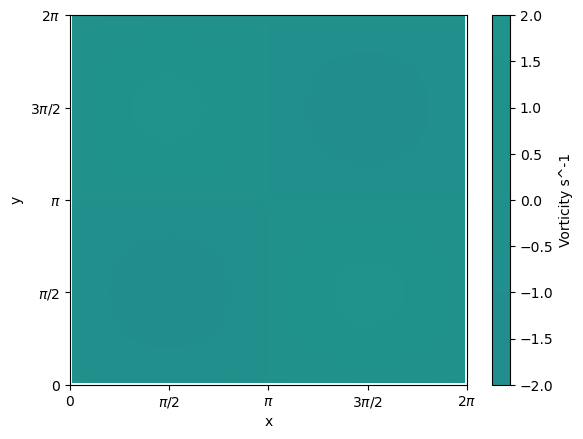

Current time: 0.06, dt: 3.6170060294313244e-06, i: 5, plot_time[i]: 0.06


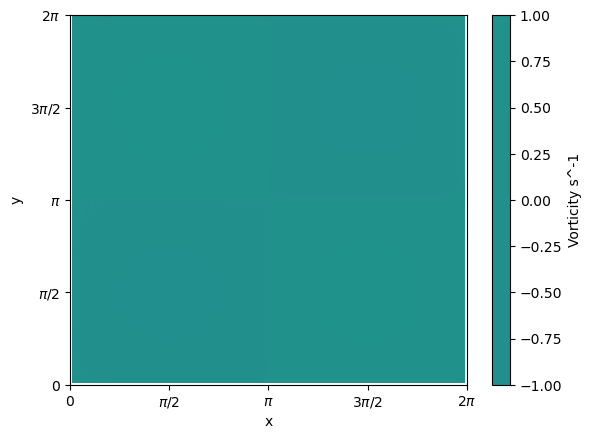

Current time: 0.07, dt: 3.485229062433204e-06, i: 6, plot_time[i]: 0.07


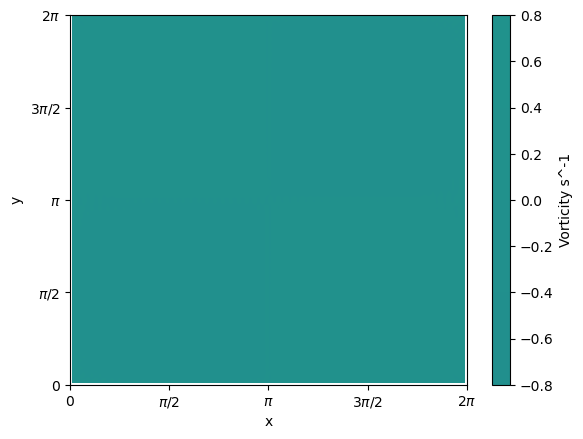

Current time: 0.08, dt: 3.5462360587629194e-06, i: 7, plot_time[i]: 0.08


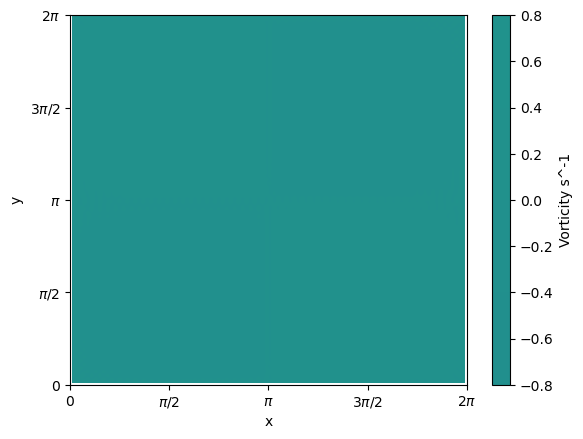

KeyboardInterrupt: 

In [62]:
# Main Code

current_time    = 0
iter            = 0     # Counter for simulation
i               = 0     # Counter for plotting

# Fill ghost cells
V = Ghost_Cells.fill_ghost_cells_2D(V, order)
P = Ghost_Cells.fill_ghost_cells_2D_single(P, order)
T = Ghost_Cells.fill_ghost_cells_2D_single(T, order)

Q = get_Q_from_V(V, Q, order) # Get Q from V
Q = Ghost_Cells.fill_ghost_cells_2D(Q, order) # Fill ghost cells

overshoot       = False # Overshoot flags

# for plotting
KE          = []
Entrophy    = []
time        = []

while current_time < t_end and iter < iter_end:
 
    # # Calculate P, T and tau_xx, tau_yy, tau_xy = tau_yx
    T = EquationOfState.Temperature_from_internal_energy(e, C_v, order)
    P = EquationOfState.calculate_pressure_from_temperature(V, R_s, T, order) 
    
    dt      = Time_Step.dt_2D(V, mu, dx, dy, CFL, ngc, R_s, gamma, T)
    
    # Check overshooting of plot times, this ensures plot time to be exact
    if current_time + dt > plot_time[i]:
        # Take the smallest time step
        dt = plot_time[i] - current_time
        overshoot = True
                                        
    # First Derivatives
    dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order) 
    dV_dy = FiniteDifference_2D.df_dy_2D(V, dy, order)
    
    dT_dx = FiniteDifference_2D_single.df_dx_2D(T, dx, order)
    dT_dy = FiniteDifference_2D_single.df_dy_2D(T, dy, order)
    
    # Second Derivatives
    d2Dx_dx2   = FiniteDifference_2D.d2f_dx2_2D(Dx, dx, order)
    d2Dy_dy2   = FiniteDifference_2D.d2f_dy2_2D(Dy, dy, order)
  
    # Calculate tau
    tau, tau_xx, tau_yy, tau_xy, tau_yx = calculate_tau(tau, dV_dx, dV_dy, mu, order) # Calculate Tau

    # Get fluxes
    Cx, Cy = get_Convective_flux(V, Q, Cx, Cy, P, order) # Convective fluxes
    Dx, Dy = get_Diffusive_flux(V, Q, dT_dx, dT_dy, Dx, Dy, tau_xx, tau_yy, tau_xy, tau_yx, gamma, order) # Diffusive fluxes  
    
    dCx_dx     = FiniteDifference_2D.df_dx_2D(Cx, dx, order)
    dCy_dy     = FiniteDifference_2D.df_dy_2D(Cy, dy, order)
    
    dDx_dx     = FiniteDifference_2D.df_dx_2D(Dx, dx, order)
    dDy_dy     = FiniteDifference_2D.df_dy_2D(Dy, dy, order)  
                                                        
    # Time Integration for momentum  
    
    # Continuity equation for species 0
    Q[:,:, 0] += dt * (-(dCx_dx[:,:,0] + dCy_dy[:,:,0]) + dDx_dx[:,:,0] + dDy_dy[:,:,0])
    
    # Continuity equation for species 1
    Q[:,:, 4] += dt * (-(dCx_dx[:,:,4] + dCy_dy[:,:,4]) + dDx_dx[:,:,4] + dDy_dy[:,:,4])      
    # x-dir momentum    
    Q[:,:, 1] += dt * (-(dCx_dx[:,:,1] + dCy_dy[:,:,1]) + dDx_dx[:,:,1] + dDy_dy[:,:,1]) 
    
    # y-dir momentum
    Q[:,:, 2] += dt * (-(dCx_dx[:,:,2] + dCy_dy[:,:,2]) + dDx_dx[:,:,2] + dDy_dy[:,:,2])
    
    # Energy equation
    Q[:,:, 3] += dt * (-(dCx_dx[:,:,3] + dCy_dy[:,:,3]) + dDx_dx[:,:,3] + dDy_dy[:,:,3])
    
    # OR
    # Q[:,:,:] += dt *(-(dCx_dx + dCy_dy) + dDx_dx + dDy_dy)

    # Update ghost cells for new Q
    Q       = Ghost_Cells.fill_ghost_cells_2D(Q, order)
    
    V       = get_V_from_Q(Q, V, order) # Get V from Q
    
    # Internal energy from V
    e = V[:,:,3] - 0.5*(V[:,:,1]**2 + V[:,:,2]**2)
    e = Ghost_Cells.fill_ghost_cells_2D_single(e, order)
    
    # Vorticity Calculation
    dV_dx = FiniteDifference_2D.df_dx_2D(V, dx, order)
    dV_dy = FiniteDifference_2D.df_dy_2D(V, dy, order)
    vorticity = dV_dy[:,:,1] - dV_dx[:,:,2] 
    vorticity = Ghost_Cells.fill_ghost_cells_2D_single(vorticity, order) 
    
    
    # For plotting KE and Entropy vs time
    
    KE.append(0.5*np.mean(V[:,:,0]*(V[:,:,1]**2 + V[:,:,2]**2)))
    
    Entrophy.append(np.mean(vorticity**2))

    time.append(current_time)
    
    current_time    += dt       # Update time     
    iter            += 1        # Update iteration
    
    # If overshoot is true, plot   
    if overshoot == True:
        
        print(f"Current time: {current_time}, dt: {dt}, i: {i}, plot_time[i]: {plot_time[i]}")       
        
        # Plot the vorticity field
        fig1 = pyplot.figure()
        ax1 = pyplot.contourf(X, Z, vorticity[ngc:-ngc, ngc:-ngc], vmin=-60, vmax=60)  
        pyplot.colorbar(ax1, label='Vorticity s^-1')
        # pyplot.set_cmap('jet')
        pyplot.xlabel('x')
        pyplot.ylabel('y')
        
        # Set x and y axis in terms of pi
        xticks = np.arange(0, 2 * np.pi + np.pi / 2, np.pi / 2)
        xtick_labels = ['0', '$\\pi/2$', '$\\pi$', '$3\\pi/2$', '$2\\pi$']
        pyplot.xticks(xticks, xtick_labels)
        pyplot.yticks(xticks, xtick_labels)

        # pyplot.title('Vorticity Field')
        pyplot.show()
        
        # u velocity
        # fig2 = pyplot.figure()
        # ax2 = pyplot.contourf(X, Y, V[ngc:-ngc, ngc:-ngc, 1])
        # pyplot.colorbar(ax2, label='u velocity')
        # pyplot.xlabel('x')
        # pyplot.ylabel('y')
        # pyplot.title('u velocity Field')
        # pyplot.show()
        
        
        # If want to plot pressure and temp
        # New pressure and temperature from internal energy
        # P = EquationOfState.Pressure_from_internal_energy(V, e, gamma, order)
        # T = EquationOfState.Temperature_from_internal_energy(e, C_v, order)
                                
        i += 1
        overshoot = False
        


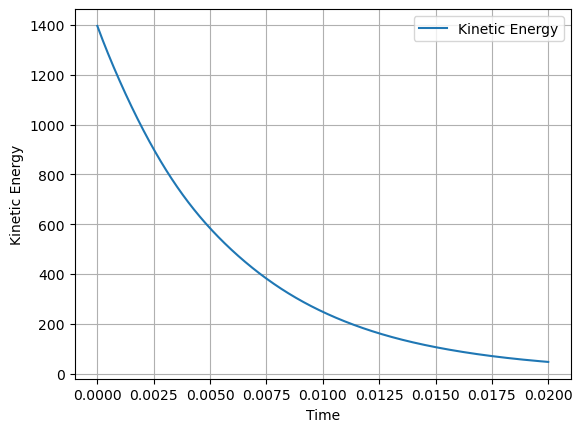

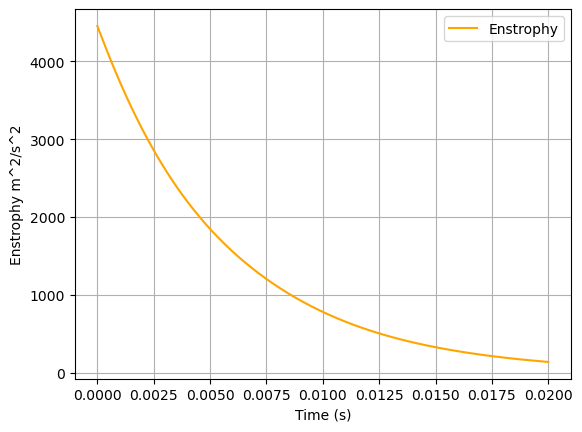

In [ ]:
pyplot.figure()
pyplot.plot(time, KE, label="Kinetic Energy")
pyplot.xlabel("Time")
pyplot.ylabel("Kinetic Energy")
# pyplot.title("Kinetic Energy vs Time")
pyplot.legend()
pyplot.grid()
pyplot.show()

pyplot.figure()
pyplot.plot(time, Entrophy, label="Enstrophy", color="orange")
pyplot.xlabel("Time (s)")
pyplot.ylabel("Enstrophy m^2/s^2")
# pyplot.title("Entrophy vs Time")
pyplot.legend()
pyplot.grid()
pyplot.show()

In [ ]:
# Save KE and time for the current run
run_id = "Res 100"  # Change this for each run
np.savetxt(f"KE_time_{run_id}.txt", np.column_stack((time, KE)), header="Time\tKinetic Energy", comments="", fmt="%.6f")

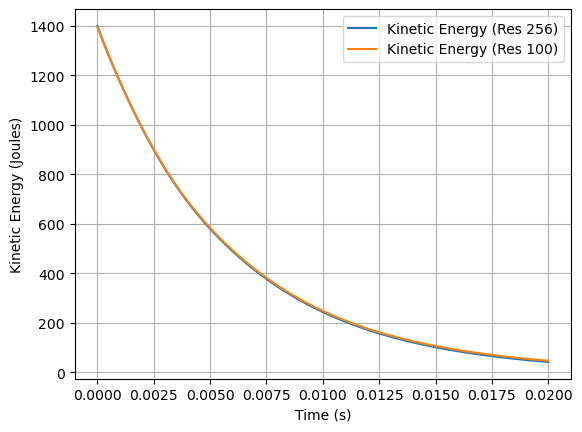

In [ ]:
# List of run identifiers
run_ids = ["Res 256", "Res 100"]  # Add all run IDs here

pyplot.figure()

# Loop through each run and plot its data
for run_id in run_ids:
    data = np.loadtxt(f"KE_time_{run_id}.txt", skiprows=1)
    time = data[:, 0]
    KE = data[:, 1]
    pyplot.plot(time, KE, label=f"Kinetic Energy ({run_id})")

# Add labels, legend, and grid
pyplot.xlabel("Time (s)")
pyplot.ylabel("Kinetic Energy (Joules)")
pyplot.legend()
pyplot.grid()
pyplot.show()